# Ames Iowa House Price Predictions: Modeling
In this notebook I will iterate through a series of linear regression models to select the one that yields the best and most consistent predictions. Throughout the notebook, I will be comparing each model to the benchmark model already in use by the mock real estate investment advisroy group that for which I am providing consulting. Success of the model will be defined by a significant improvement (I am hoping for at least 30-40% reduction in Mean Absolute Error) over the benchmark model already in production.

In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model_helpers import drop_max_vif, ordinalize, box_plot_columns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import RidgeCV, LassoCV

# Import Cleaned Data

In [114]:
df = pd.read_csv('./datasets/train_cleaned_outliers_removed.csv')
kdf = pd.read_csv('./datasets/test_cleaned.csv')

X = pd.read_csv('./datasets/training_data_encoded.csv')
X_k = pd.read_csv('./datasets/kaggle_data_encoded.csv')

y = df['saleprice']
log_y = np.log(df['saleprice'])

In [115]:
sns.set_style('darkgrid')

title_font = {
    'family': 'calibri',
    'color': 'black',
    'size': '30',
    'weight': 'bold'
}

label_font = {
    'family': 'calibri',
    'color': 'black',
    'size': '20',
    'weight': 'semibold'
}

ticks_font = {
    'family': 'calibri',
    'color': 'black',
    'size': '15',
    'weight': 'semibold'
}

# Split Training and Testing Data

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    log_y, 
                                                    random_state = 42
                                                   )

# Null Model

In [117]:
baseline=np.full_like(y, y.mean())  # Idea from Eric Bayles, "Transformers and Preprocessing"


In [118]:
print(
    f"""
    R2 Score: {r2_score(y, baseline)}
    MSE: {mean_squared_error(y, baseline)}
    RMSE: {mean_squared_error(y, baseline, squared=False)}
    MAE: {mean_absolute_error(y, baseline)}
    """
     )


    R2 Score: -5.1958437552457326e-14
    MSE: 6284773122.026842
    RMSE: 79276.56098763898
    MAE: 58406.4289897511
    


# Benchmark Model

In [119]:
X_b = df[['gr_liv_area', 'lot_area', 'year_built', 'overall_cond']]

In [120]:
X_btrain, X_btest, y_btrain, y_btest = train_test_split(X_b, 
                                                        y, 
                                                        random_state = 42
                                                       )

In [121]:
lr_b = LinearRegression()
lr_b.fit(X_btrain, y_btrain)
benchmark_preds = lr_b.predict(X_btest)
print(
    f"""
    R2 Score: {r2_score(y_btest, benchmark_preds)}
    MSE: {mean_squared_error(y_btest, benchmark_preds)}
    RMSE: {mean_squared_error(y_btest, benchmark_preds, squared=False)}
    MAE: {mean_absolute_error(y_btest, benchmark_preds)}
    """
     )


    R2 Score: 0.6908734382299984
    MSE: 1954333537.5985525
    RMSE: 44207.8447517921
    MAE: 30986.407335099582
    


**The benchmark model already used by the real estate investment advisory group alreay well outperforms the null model, reducing mean absolute error by 50% and accounting for about 70% of the variability in housing prices.**

In [122]:
sorted(list(zip(lr_b.coef_, lr_b.feature_names_in_)), reverse=True)

[(10082.424504043056, 'overall_cond'),
 (1252.549177672548, 'year_built'),
 (92.48694859526907, 'gr_liv_area'),
 (1.8123491515453223, 'lot_area')]

**One of the benefits of the benchmark model is the interpretability of the coefficients. By preserving the original units of all features and the sale price, it is easy to see how the model is counting each feature unit. However, with the evidence of heteroskedasticity in the residual plot, there are concerns about whether the inferences of this model will be reliable.**

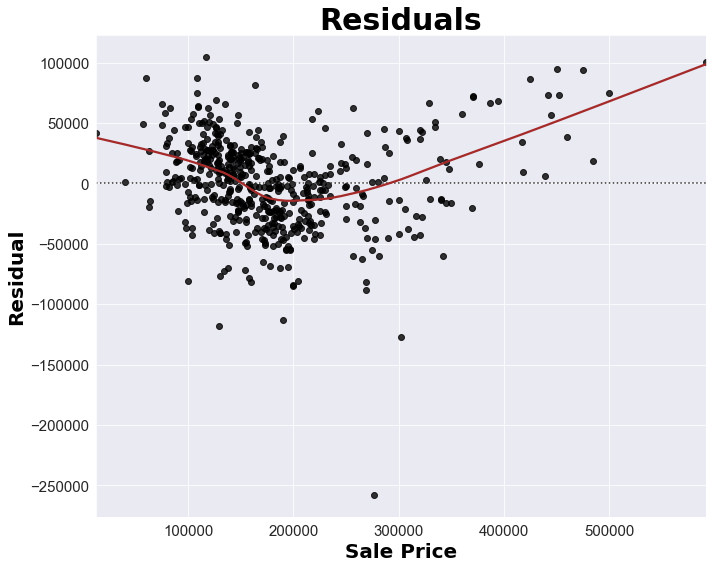

In [173]:
benchmark_residuals = y_btest - benchmark_preds
plt.figure(figsize=(10, 8))

sns.residplot(x = y_btest, 
              y = benchmark_residuals,
              lowess=True,
              color='black',
              line_kws={'color': 'brown'}
             )
plt.title('Residuals', title_font)
plt.xlabel('Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('./images/benchmark_resids');

**The residuals plot clearly illustrates the importance of log transformations for obtaining accurate predictions. There is a significant decrease in performance at both the higher and the lower end of the price range.**

# OLS Linear Regression

In [124]:
lr_ols = LinearRegression()
lr_ols.fit(X_train, y_train)
ols_preds = lr_ols.predict(X_test)
ols_preds_exp = np.exp(ols_preds)
y_test_exp = np.exp(y_test)

In [125]:
print(
    f"""
    CV 5: {cross_val_score(lr_ols, X_train, y_train)}
    CV Mean: {cross_val_score(lr_ols, X_train, y_train).mean()}
    R2 Score: {r2_score(y_test, ols_preds)}
    MSE: {mean_squared_error(y_test_exp, ols_preds_exp)}
    RMSE: {mean_squared_error(y_test_exp, ols_preds_exp, squared=False)}
    MAE: {mean_absolute_error(y_test_exp, ols_preds_exp)}
    """
     )


    CV 5: [0.91340282 0.91751418 0.87731244 0.8738699  0.8843326 ]
    CV Mean: 0.8932863881146357
    R2 Score: 0.8878230926787489
    MSE: 438710045.6301924
    RMSE: 20945.406313323034
    MAE: 14922.925100658253
    


**The first iteration of an OLS Linear Regression, taking advantage of strategic usage of log transformations resulting in a model that performed significantly better than the benchmark**

In [126]:
sorted(list(zip(lr_ols.coef_, lr_ols.feature_names_in_)), reverse=True)[:10]

[(2.130446963814426, 'year_built'),
 (2.128234791581104, 'age'),
 (0.7361627514634276, 'pool_qc_Gd'),
 (0.6302460841317638, 'pool_qc_Fa'),
 (0.5169981158891933, 'gr_liv_area'),
 (0.45951966954696605, 'pool_qc_TA'),
 (0.4463158064426663, 'ms_zoning_FV'),
 (0.40997915437071836, 'ms_zoning_RH'),
 (0.3890899345995368, 'ms_zoning_RL'),
 (0.37378066313559444, 'ms_zoning_RM')]

In [127]:
sorted(list(zip(lr_ols.coef_, lr_ols.feature_names_in_)), reverse=True)[-10:]

[(-0.27507621996699044, 'misc_feature_TenC'),
 (-0.29001443500407653, 'garage_qual_Gd'),
 (-0.29532178533877906, 'garage_qual_TA'),
 (-0.3147640430309798, 'garage_qual_Fa'),
 (-0.3270275931138318, 'total_baths'),
 (-0.37458053321965823, 'pool_area'),
 (-0.39507395203894463, 'heating_Grav'),
 (-0.6803504878522963, 'functional_Sal'),
 (-1.8258765268260062, 'pool_qc_None'),
 (-4284.101810482954, 'yr_sold')]

**The year sold has a really exaggerated coefficient. Due to the feature and target transformations, it is difficult to say exactly what can be inferred by this inflated coefficient, but it is something that may warrant further research as the model is tuned in the future.**

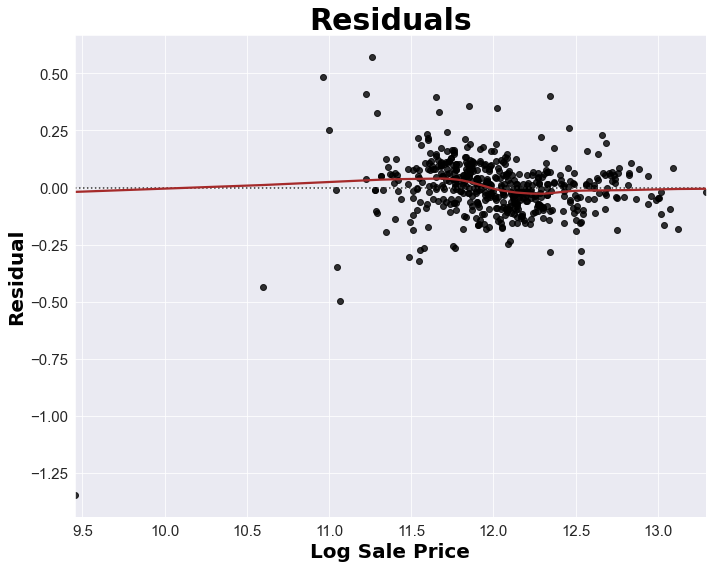

In [128]:
ols_resids = y_test - ols_preds

plt.figure(figsize=(10, 8))

sns.residplot(x = y_test, 
              y = ols_resids,
              lowess=True,
              color='black',
              line_kws={'color': 'brown'}
             )
plt.title('Residuals', title_font)
plt.xlabel('Log Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**The residual plot looks relatively random, with little evidence of heteroskedasticity**

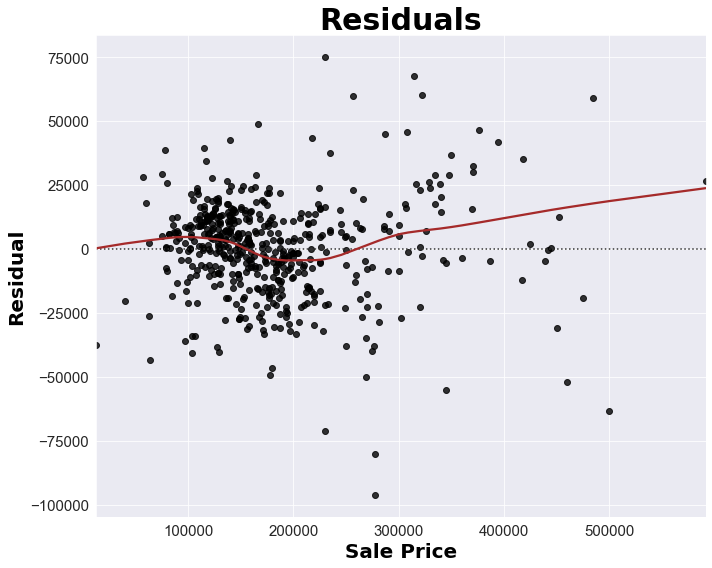

In [129]:
ols_resids_exp = y_test_exp - ols_preds_exp

plt.figure(figsize=(10, 8))

sns.residplot(x = y_test_exp, 
              y = ols_resids_exp,
              lowess=True,
              color='black',
              line_kws={'color': 'brown'}
             )
plt.title('Residuals', title_font)
plt.xlabel('Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**With the predictions scaled back to price instead of log of price, there is a little bit more heteroskedasticity that is evident, but it is still a marked improvement over the benchmark model.**

# Filter High get_params
The iteration of the model will automatically drop all of the features that have high variance inflation factors in order to minimize multicolinearity.

In [130]:
X_v_filter, v_filter_drop = drop_max_vif(X, threshold=100)

/Users/jacksonnelson/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping misc_feature_TenC with a VIF of inf


/Users/jacksonnelson/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping garage_cond_None with a VIF of inf


/Users/jacksonnelson/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


Dropping utilities_NoSewr with a VIF of inf
Dropping roof_matl_CompShg with a VIF of 1286742750677284.5
Dropping yr_sold with a VIF of 4068408.141589898
Dropping pool_qc_None with a VIF of 381035.5115095538
Dropping total_area with a VIF of 43732.3487504191
Dropping year_built with a VIF of 36904.357249723034
Dropping gr_liv_area with a VIF of 17836.611107398076
Dropping year_remod/add with a VIF of 11351.934736326457
Dropping misc_feature_None with a VIF of 4674.551422424707
Dropping garage_cond_TA with a VIF of 3878.14679162427
Dropping 1st_flr_sf with a VIF of 3788.3299908083022
Dropping room_size with a VIF of 1609.4423970387318
Dropping lot_area with a VIF of 1227.8970180848164
Dropping ms_zoning_RL with a VIF of 961.1369400535909
Dropping total_baths with a VIF of 888.6876579818954
Dropping garage_qual_TA with a VIF of 603.4972395232921
Dropping bsmt_cond_TA with a VIF of 520.0193799253011
Dropping lot_frontage with a VIF of 493.5838830132914
Dropping condition_2_Norm with a VIF 

In [131]:
X_v_train, X_v_test, y_v_train, y_v_test = train_test_split(X_v_filter, 
                                                            log_y, 
                                                            random_state = 42
                                                           )

In [132]:
lr_vif = LinearRegression()
lr_vif.fit(X_v_train, y_v_train)
vif_preds = lr_vif.predict(X_v_test)
vif_preds_exp = np.exp(vif_preds)
y_v_test_exp = np.exp(y_v_test)

print(
    f"""
    CV 5: {cross_val_score(lr_vif, X_v_train, y_v_train)}
    CV Mean: {cross_val_score(lr_vif, X_v_train, y_v_train).mean()}
    R2 Score: {r2_score(y_test_exp, vif_preds_exp)}
    MSE: {mean_squared_error(y_test_exp, vif_preds_exp)}
    RMSE: {mean_squared_error(y_test_exp, vif_preds_exp, squared=False)}
     MAE: {mean_absolute_error(y_test_exp, vif_preds_exp)}
    """
     )


    CV 5: [0.87191635 0.87818464 0.87703021 0.85418104 0.83684357]
    CV Mean: 0.8636311623653121
    R2 Score: 0.8484833233818935
    MSE: 957905787.5995675
    RMSE: 30950.053111417557
     MAE: 19235.971514282504
    


**Performance was reduced when compared to the OLS model, though this approach does show some promise if refined to be more selective about how it decides to remove features.**

In [133]:
sorted(list(zip(lr_vif.coef_, lr_vif.feature_names_in_)), reverse=True)[:10]

[(0.5330966178059878, 'bsmt_cond_None'),
 (0.2411703410356199, 'roof_matl_WdShngl'),
 (0.23456476673074841, 'pool_area'),
 (0.2067415927577018, 'roof_matl_Membran'),
 (0.1611167714967869, 'house_style_2.5Fin'),
 (0.15927880844976433, 'house_style_1.5Unf'),
 (0.15629546740828865, 'condition_1_PosA'),
 (0.15164304828094666, 'house_style_2.5Unf'),
 (0.11935071872499786, 'central_air'),
 (0.11348753891345999, 'condition_1_PosN')]

In [134]:
sorted(list(zip(lr_vif.coef_, lr_vif.feature_names_in_)), reverse=True)[-10:]

[(-0.18073210093946804, 'roof_style_Mansard'),
 (-0.18205456208419943, 'functional_Maj2'),
 (-0.19668386759159928, 'bldg_type_Twnhs'),
 (-0.2859520824204375, 'ms_zoning_C (all)'),
 (-0.35104109556364554, 'bsmtfin_type_2_None'),
 (-0.36130271018432464, 'heating_Grav'),
 (-1.172354379433657, 'functional_Sal'),
 (-1.1788217878929568, 'pool_qc_TA'),
 (-1.4110519722707466, 'pool_qc_Gd'),
 (-1.5162279818949684, 'pool_qc_Fa')]

**The coefficients of this model look very reasonable. I think this model could be one of the most promising with some more work put into making it perform more reliably.**

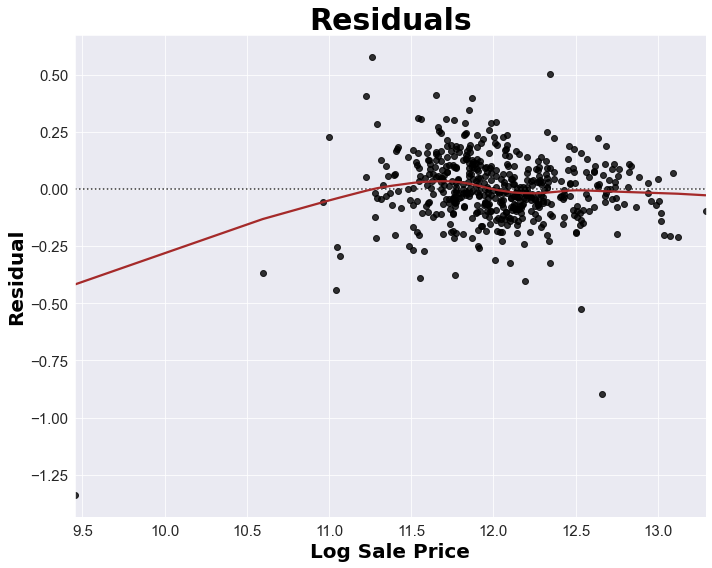

In [135]:
vif_resids = y_v_test - vif_preds

plt.figure(figsize=(10, 8))

sns.residplot(x = y_v_test, 
              y = vif_resids,
              color='black',
              lowess=True,
              line_kws={'color': 'brown'}
               )
plt.title('Residuals', title_font)
plt.xlabel('Log Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**This residual plot looks pretty good, but the one below with prices scaled back to dollars shows one large residual that is really punishing the performance of this model.**

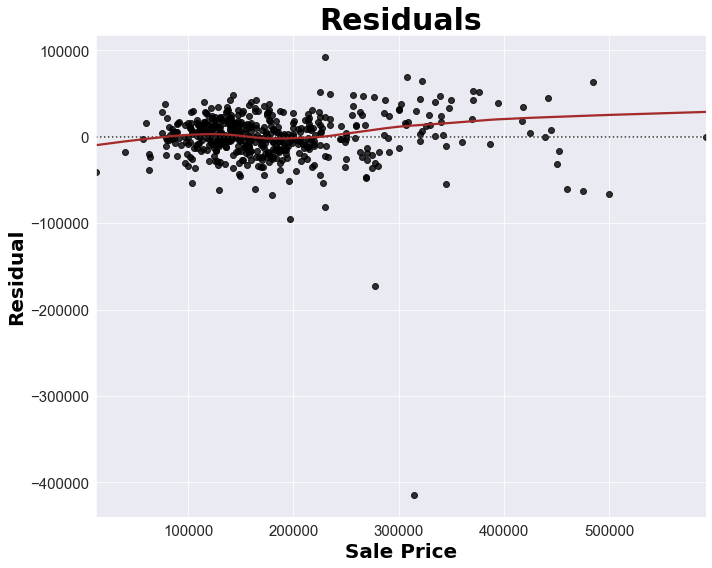

In [136]:
vif_resids_exp = y_v_test_exp - vif_preds_exp

plt.figure(figsize=(10, 8))

sns.residplot(x = y_v_test_exp, 
              y = vif_resids_exp,
              color='black',
              lowess=True,
              line_kws={'color': 'brown'}
               )
plt.title('Residuals', title_font)
plt.xlabel('Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**More research needs to be done about where this model went wrong. I looks like the model must have guessed a negative price one of the houses. While this approach is promising, it is not fit for production.**

# RidgeCV

In [137]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train)
Z_test = sc.transform(X_test)

In [138]:
r_alphas = np.logspace(0, 5, 1000)
clf = RidgeCV(alphas=r_alphas, cv=5)
clf.fit(Z_train, y_train)

RidgeCV(alphas=array([1.00000000e+00, 1.01159111e+00, 1.02331658e+00, 1.03517796e+00,
       1.04717682e+00, 1.05931476e+00, 1.07159340e+00, 1.08401436e+00,
       1.09657929e+00, 1.10928986e+00, 1.12214777e+00, 1.13515471e+00,
       1.14831241e+00, 1.16162263e+00, 1.17508713e+00, 1.18870770e+00,
       1.20248614e+00, 1.21642429e+00, 1.23052400e+00, 1.24478715e+00,
       1.25921561e+00, 1.27381132e+0...
       7.67158118e+04, 7.76050334e+04, 7.85045620e+04, 7.94145172e+04,
       8.03350198e+04, 8.12661920e+04, 8.22081576e+04, 8.31610415e+04,
       8.41249705e+04, 8.51000725e+04, 8.60864770e+04, 8.70843150e+04,
       8.80937190e+04, 8.91148232e+04, 9.01477631e+04, 9.11926760e+04,
       9.22497005e+04, 9.33189772e+04, 9.44006479e+04, 9.54948564e+04,
       9.66017480e+04, 9.77214697e+04, 9.88541702e+04, 1.00000000e+05]),
        cv=5)

In [139]:
clf.alpha_

191.55005555735278

In [140]:
clf.best_score_

0.9054722182854663

In [141]:
clf.score(Z_test, y_test)

0.8851073556184532

In [142]:
ridge_preds = clf.predict(Z_test)
ridge_preds_exp = np.exp(ridge_preds)

print(
    f"""
    R2 Score: {r2_score(y_test, ridge_preds)}
    MSE: {mean_squared_error(y_test_exp, ridge_preds_exp)}
    RMSE: {mean_squared_error(y_test_exp, ridge_preds_exp, squared=False)}
    MAE: {mean_absolute_error(y_test_exp, ridge_preds_exp)}
    """
     )


    R2 Score: 0.8851073556184532
    MSE: 496907850.06065565
    RMSE: 22291.429968951197
    MAE: 15605.077529935656
    


**Surprisingly, the ridge model did not perform quite as well as the OLS model, though it is likely less overfit. With the two models performing similarly, I would still probably pick the ridge over the OLS because I am more confident that it would generalize well to unseen data.**

In [143]:
sorted(list(zip(clf.coef_, sc.get_feature_names_out())), reverse=True)[:10]

[(0.07762561281330062, 'overall_qual'),
 (0.05910171141633416, 'gr_liv_area'),
 (0.04059869271442199, 'total_bsmt_sf'),
 (0.04031757767212794, 'total_area'),
 (0.0346726895801151, 'year_remod/add'),
 (0.03351893484300744, 'overall_cond'),
 (0.03268041074002102, '1st_flr_sf'),
 (0.030458491801997757, 'lot_area'),
 (0.027086490544592976, 'year_built'),
 (0.023556331400493895, 'fireplaces')]

In [144]:
sorted(list(zip(clf.coef_, sc.get_feature_names_out())), reverse=True)[-10:]

[(-0.008702773847736763, 'house_style_1Story'),
 (-0.009070808993525525, 'bldg_type_Duplex'),
 (-0.010132969675931129, 'kitchen_abvgr'),
 (-0.010191604739353408, 'bsmt_unf_sf'),
 (-0.01081444106917385, 'roof_style_Mansard'),
 (-0.011541088545426476, 'bsmt_exposure_No'),
 (-0.016634220250411214, 'heating_Grav'),
 (-0.01905098022060968, 'ms_zoning_C (all)'),
 (-0.02723692614256614, 'age'),
 (-0.0309458196432429, 'functional_Sal')]

**As expected, the coefficients of the Ridge model are also reasonably weighted, by nature of the penalty term applied as the model is being fit.**

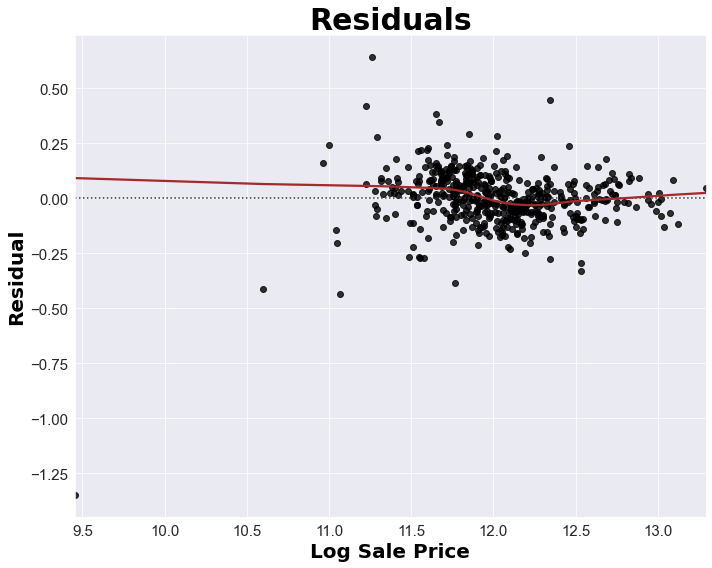

In [145]:
ridge_resids = y_test - ridge_preds

plt.figure(figsize=(10, 8))

sns.residplot(x = y_test, 
              y = ridge_resids,
              lowess=True,
              line_kws={'color': 'brown'},
              color='black'
              )
plt.title('Residuals', title_font)
plt.xlabel('Log Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**The residuals of the ridge model are by far the best we have seen thus far. They are relatively random in their distribution, though there is still one outlier in the bottom left corner.**

<Figure size 720x576 with 0 Axes>

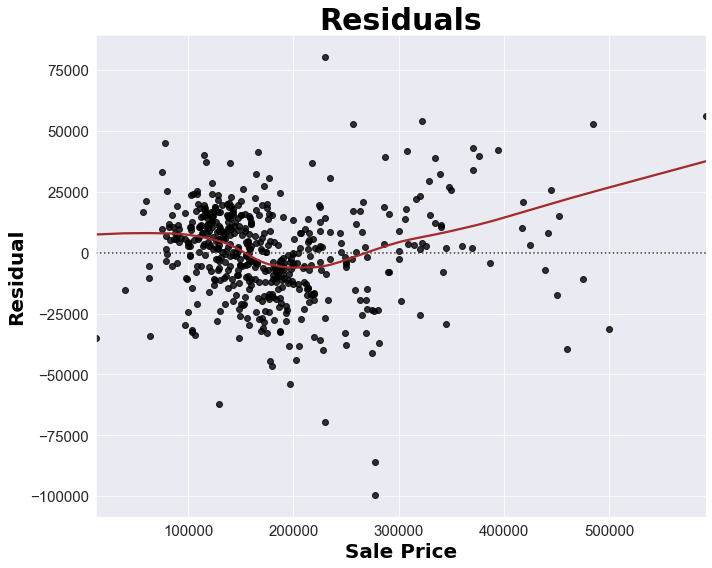

In [146]:
ridge_resids_exp = y_test_exp - ridge_preds_exp

plt.figure(figsize=(10, 8))

plt.figure(figsize=(10, 8))

sns.residplot(x = y_test_exp, 
              y = ridge_resids_exp,
              lowess=True,
              line_kws={'color': 'brown'},
              color='black'
              )
plt.title('Residuals', title_font)
plt.xlabel('Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout();

**The residuals scaled to the sale price in dollars still look fairly good, though there is a more evident pattern. It is still much better than the benchmark model.**

# LassoCV

In [147]:
l_alphas = np.logspace(-3, 0, 1000)
lasso = LassoCV(alphas=l_alphas)
lasso.fit(Z_train, y_train)

LassoCV(alphas=array([0.001     , 0.00100694, 0.00101393, 0.00102096, 0.00102804,
       0.00103518, 0.00104236, 0.00104959, 0.00105688, 0.00106421,
       0.00107159, 0.00107903, 0.00108652, 0.00109405, 0.00110165,
       0.00110929, 0.00111699, 0.00112474, 0.00113254, 0.0011404 ,
       0.00114831, 0.00115628, 0.0011643 , 0.00117238, 0.00118052,
       0.00118871, 0.00119696, 0.00120526, 0.00121362, 0.00122204,
       0.001...
       0.79049276, 0.7959777 , 0.8015007 , 0.80706201, 0.81266192,
       0.81830068, 0.82397857, 0.82969585, 0.83545281, 0.8412497 ,
       0.84708683, 0.85296445, 0.85888286, 0.86484233, 0.87084315,
       0.87688561, 0.88297   , 0.8890966 , 0.89526571, 0.90147763,
       0.90773265, 0.91403107, 0.9203732 , 0.92675933, 0.93318977,
       0.93966483, 0.94618482, 0.95275005, 0.95936083, 0.96601748,
       0.97272032, 0.97946967, 0.98626585, 0.99310918, 1.        ]))

In [148]:
lasso.alpha_

0.003593813663804626

In [149]:
lasso.score(Z_train, y_train)

0.9277615521539244

In [150]:
lasso_preds = lasso.predict(Z_test)
lasso_preds_exp = np.exp(lasso_preds)

print(
    f"""
    R2 Score: {r2_score(y_test, lasso_preds)}
    MSE: {mean_squared_error(y_test_exp, lasso_preds_exp)}
    RMSE: {mean_squared_error(y_test_exp, lasso_preds_exp, squared=False)}
    MAE: {mean_absolute_error(y_test_exp, lasso_preds_exp)}
    """
     )


    R2 Score: 0.8905087540246492
    MSE: 442760005.1982824
    RMSE: 21041.863158909728
    MAE: 14930.887919141396
    


**The Lasso model is the best performing model yet, and the model I would choose for production. The coefficients below are reasonable, the model is accounting for around 90% of the variance in sales price, and the mean absolute error have been reduced by over 50% compared to the benchmark.

In [151]:
sorted(list(zip(lasso.coef_, sc.get_feature_names_out())), reverse=True)[:10]

[(0.13630196987430143, 'gr_liv_area'),
 (0.10296020431503446, 'overall_qual'),
 (0.05288180612335919, 'total_bsmt_sf'),
 (0.04008065203164322, 'lot_area'),
 (0.03586121180348444, 'overall_cond'),
 (0.034727633413464916, 'year_remod/add'),
 (0.02402253174074413, 'garage_area'),
 (0.020381935205545473, 'fireplaces'),
 (0.0142635061961958, 'bsmtfin_sf_1'),
 (0.013362006365692207, 'bsmt_full_bath')]

In [152]:
sorted(list(zip(lasso.coef_, sc.get_feature_names_out())), reverse=True)[-10:]

[(-0.0052322255495948385, 'bsmt_exposure_No'),
 (-0.006657478664721922, 'functional_Maj2'),
 (-0.007117302532519625, 'bedroom_abvgr'),
 (-0.00766815494712738, 'roof_style_Mansard'),
 (-0.010631096019646477, 'bsmt_unf_sf'),
 (-0.0123716416445989, 'kitchen_abvgr'),
 (-0.01565510181111673, 'heating_Grav'),
 (-0.01826357827450475, 'ms_zoning_C (all)'),
 (-0.03242943988457655, 'functional_Sal'),
 (-0.06444598758268484, 'age')]

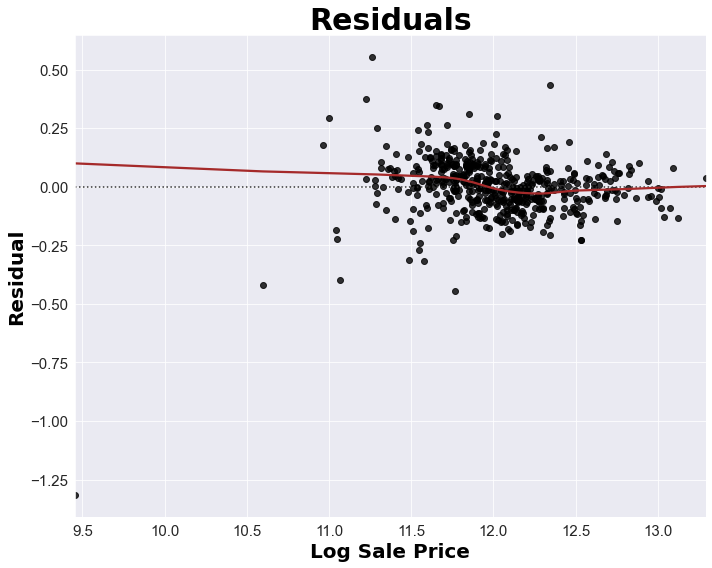

In [174]:
lasso_resids = y_test - lasso_preds

plt.figure(figsize=(10, 8))

sns.residplot(x = y_test, 
              y = lasso_resids,
              lowess=True,
              line_kws={'color': 'brown'},
              color='black'
              )
plt.title('Residuals', title_font)
plt.xlabel('Log Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('./images/lasso_resids.png');

**The residual plots of the lasso model are probably the best we have seen, though again I am noticing the outlier hiding in the bottom left corner. It may be worth exploring that data point as it seems to be giving all of the models trouble.**

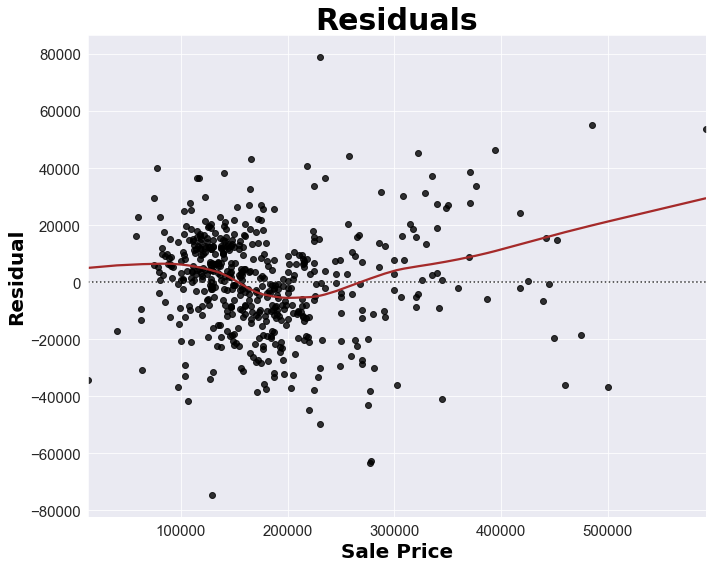

In [175]:
lasso_resids_exp = y_test_exp - lasso_preds_exp

plt.figure(figsize=(10, 8))

sns.residplot(x = y_test_exp, 
              y = lasso_resids_exp,
              lowess=True,
              line_kws={'color': 'brown'},
              color='black'
              )
plt.title('Residuals', title_font)
plt.xlabel('Sale Price', label_font)
plt.ylabel('Residual', label_font)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.tight_layout()
plt.savefig('./images/lasso_resids_exp.png');

In [155]:
coef_df = pd.DataFrame(np.abs(lasso.coef_), sc.get_feature_names_out(), columns = ['coef']).reset_index()

In [156]:
select_features = coef_df[np.abs(coef_df['coef']) != 0]['index']

In [157]:
X_select_feats = X[select_features]

In [158]:
Xs_train, Xs_test, y_train, y_test = train_test_split(X_select_feats, 
                                                    log_y, 
                                                    random_state = 42
                                                   )

# Basic Ridge and Lasso Kaggle Submissions

## Standardize Data

In [159]:
X_k.head()

,lot_frontage,lot_area,street,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,bsmtfin_sf_1,bsmtfin_sf_2,...,pool_qc_TA,fence_GdWo,fence_MnPrv,fence_MnWw,fence_None,misc_feature_Gar2,misc_feature_None,misc_feature_Othr,misc_feature_Shed,misc_feature_TenC
0,4.310605,9.120744,1,6,2.197225,1910,1950,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,3.784190,9.176059,1,5,1.609438,1977,1977,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
2,4.234107,9.747126,1,7,1.791759,2006,2006,0.000000,6.318968,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,4.304065,9.050289,1,5,1.945910,1923,2006,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,4.418841,9.159152,1,6,1.791759,1963,1963,5.513429,6.413459,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [160]:
sc_k = StandardScaler()
Z_train_kaggle = sc_k.fit_transform(X)
Z_predict_kaggle = sc_k.transform(X_k)

In [161]:
Z_train_kaggle.shape, Z_predict_kaggle.shape

((2049, 152), (878, 152))

## Kaggle Ridge

In [162]:
r_alphas = np.logspace(0, 5, 1000)
k_clf = RidgeCV(alphas=r_alphas, cv=5)
k_clf.fit(Z_train_kaggle, log_y)

RidgeCV(alphas=array([1.00000000e+00, 1.01159111e+00, 1.02331658e+00, 1.03517796e+00,
       1.04717682e+00, 1.05931476e+00, 1.07159340e+00, 1.08401436e+00,
       1.09657929e+00, 1.10928986e+00, 1.12214777e+00, 1.13515471e+00,
       1.14831241e+00, 1.16162263e+00, 1.17508713e+00, 1.18870770e+00,
       1.20248614e+00, 1.21642429e+00, 1.23052400e+00, 1.24478715e+00,
       1.25921561e+00, 1.27381132e+0...
       7.67158118e+04, 7.76050334e+04, 7.85045620e+04, 7.94145172e+04,
       8.03350198e+04, 8.12661920e+04, 8.22081576e+04, 8.31610415e+04,
       8.41249705e+04, 8.51000725e+04, 8.60864770e+04, 8.70843150e+04,
       8.80937190e+04, 8.91148232e+04, 9.01477631e+04, 9.11926760e+04,
       9.22497005e+04, 9.33189772e+04, 9.44006479e+04, 9.54948564e+04,
       9.66017480e+04, 9.77214697e+04, 9.88541702e+04, 1.00000000e+05]),
        cv=5)

In [163]:
k_clf.alpha_

210.04982416539153

In [164]:
k_clf.best_score_

0.9001555976249642

In [165]:
k_clf.score(Z_train_kaggle, log_y)

0.922671967232983

In [166]:
kaggle_ridge_preds = k_clf.predict(Z_predict_kaggle)
kaggle_ridge_preds_exp = np.exp(kaggle_ridge_preds)

In [167]:
kaggle_clf_df = kdf.copy()
kaggle_clf_df['SalePrice'] = kaggle_ridge_preds_exp
kaggle_clf_df['Id'] = kdf['id']
kaggle_clf_df[['Id', 'SalePrice']].to_csv('./datasets/ridge_cv_preds.csv', index=False)

# Kaggle Lasso

In [168]:
l_alphas = np.logspace(-3, 0, 1000)
k_lasso = LassoCV(alphas=l_alphas)
k_lasso.fit(Z_train_kaggle, log_y)

LassoCV(alphas=array([0.001     , 0.00100694, 0.00101393, 0.00102096, 0.00102804,
       0.00103518, 0.00104236, 0.00104959, 0.00105688, 0.00106421,
       0.00107159, 0.00107903, 0.00108652, 0.00109405, 0.00110165,
       0.00110929, 0.00111699, 0.00112474, 0.00113254, 0.0011404 ,
       0.00114831, 0.00115628, 0.0011643 , 0.00117238, 0.00118052,
       0.00118871, 0.00119696, 0.00120526, 0.00121362, 0.00122204,
       0.001...
       0.79049276, 0.7959777 , 0.8015007 , 0.80706201, 0.81266192,
       0.81830068, 0.82397857, 0.82969585, 0.83545281, 0.8412497 ,
       0.84708683, 0.85296445, 0.85888286, 0.86484233, 0.87084315,
       0.87688561, 0.88297   , 0.8890966 , 0.89526571, 0.90147763,
       0.90773265, 0.91403107, 0.9203732 , 0.92675933, 0.93318977,
       0.93966483, 0.94618482, 0.95275005, 0.95936083, 0.96601748,
       0.97272032, 0.97946967, 0.98626585, 0.99310918, 1.        ]))

In [169]:
k_lasso.alpha_

0.0037720424934169976

In [170]:
k_lasso.score(Z_train_kaggle, log_y)

0.9196086476607361

In [171]:
kaggle_lasso_preds = k_lasso.predict(Z_predict_kaggle)
kaggle_lasso_preds_exp = np.exp(kaggle_lasso_preds)

In [172]:
kaggle_lasso_df = kdf.copy()
kaggle_lasso_df['SalePrice'] = kaggle_lasso_preds_exp
kaggle_lasso_df['Id'] = kaggle_clf_df['Id']
kaggle_lasso_df[['Id', 'SalePrice']].to_csv('./datasets/lasso_cv_preds.csv', index=False)